# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Load data

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

# Combine datasets for consistent preprocessing

In [3]:
full_data = pd.concat([train_data, test_data], sort=False)

# Exploratory Data Analysis (EDA)

In [4]:
missing = full_data.isnull().sum()
print("\nMissing Values:\n", missing[missing > 0])


Missing Values:
 Survived     418
Age          263
Fare           1
Cabin       1014
Embarked       2
dtype: int64


# Data Visualization

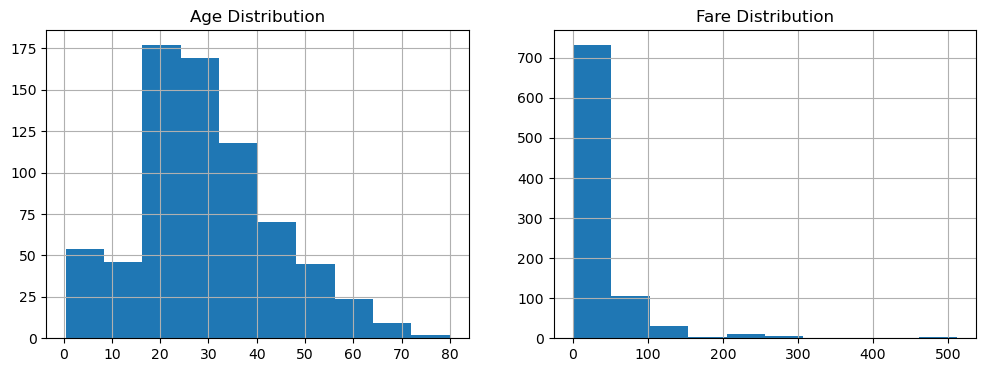

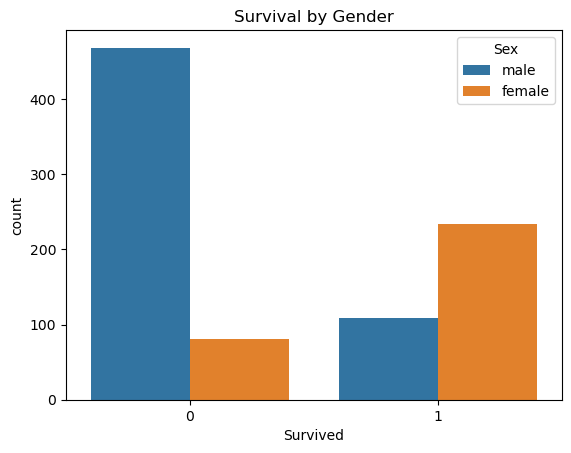

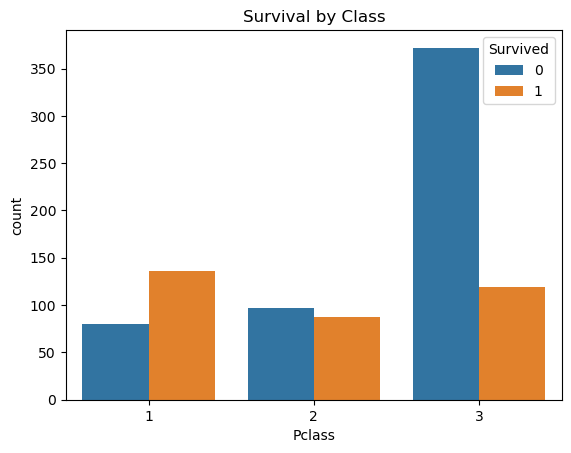

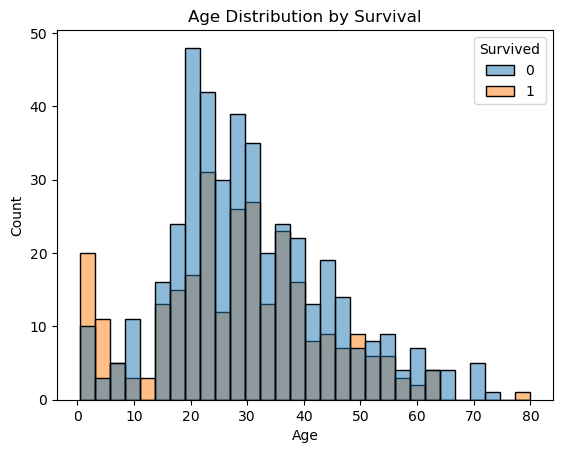

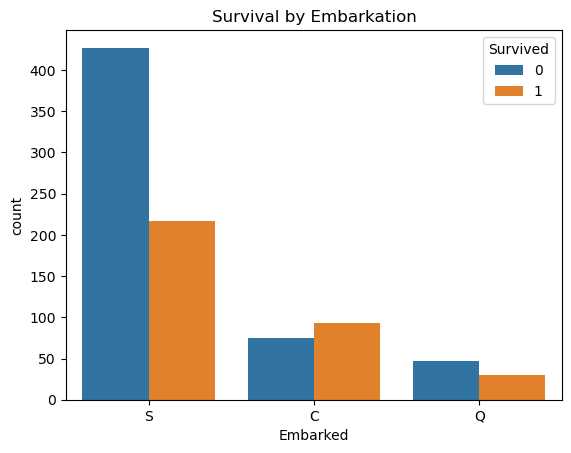

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
train_data["Age"].hist(ax=axes[0])
axes[0].set_title("Age Distribution")
train_data["Fare"].hist(ax=axes[1])
axes[1].set_title("Fare Distribution")
plt.show()

sns.countplot(x="Survived", hue="Sex", data=train_data)
plt.title("Survival by Gender")
plt.show()

sns.countplot(x="Pclass", hue="Survived", data=train_data)
plt.title("Survival by Class")
plt.show()

sns.histplot(data=train_data, x="Age", hue="Survived", bins=30)
plt.title("Age Distribution by Survival")
plt.show()

sns.countplot(x="Embarked", hue="Survived", data=train_data)
plt.title("Survival by Embarkation")
plt.show()

# Heatmap of Correlations

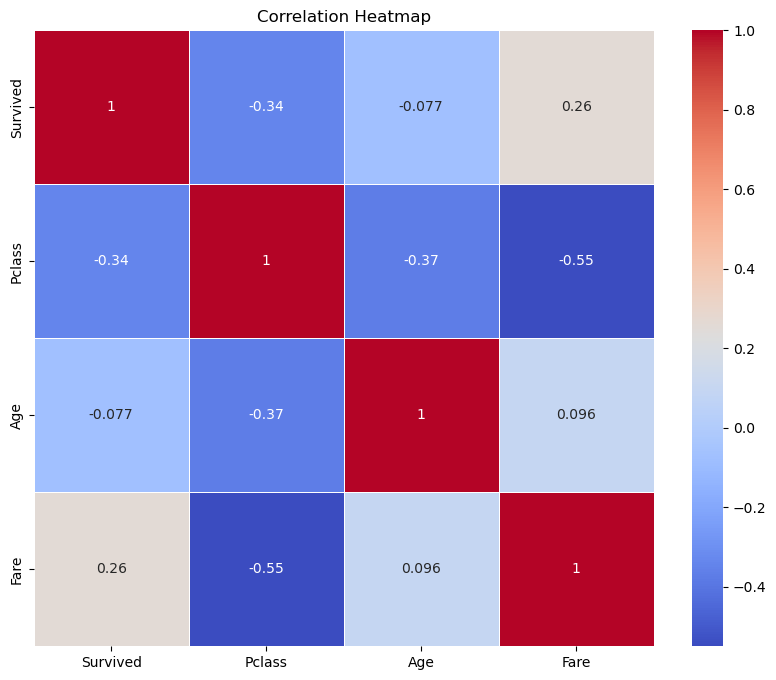

In [6]:
plt.figure(figsize=(10, 8))
numeric_corr = train_data[["Survived", "Pclass", "Age", "Fare"]].corr()
sns.heatmap(numeric_corr, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# Impute missing values

In [7]:
num_features = ["Age", "Fare"]
cat_features = ["Embarked", "Sex", "Pclass"]

full_data["Cabin"] = full_data["Cabin"].fillna("Unknown")

num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

full_data[num_features] = num_imputer.fit_transform(full_data[num_features])
full_data[cat_features] = cat_imputer.fit_transform(full_data[cat_features])

# Encode categorical features

In [8]:
X_full = full_data[["Pclass", "Sex", "Age", "Fare", "Embarked"]]
y = train_data["Survived"]

# Define preprocessor with OneHotEncoding 

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["Pclass", "Sex", "Embarked"]),
    ],
    remainder="passthrough",  # Keep numerical columns as-is
)

# Pipeline Setup

In [10]:
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", DecisionTreeClassifier(random_state=42)),
    ]
)

# Split train.csv to Train/Validation 

In [11]:
X = X_full.iloc[: len(train_data)]
X_test_final = X_full.iloc[len(train_data) :]


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Grid search for best parameters

In [12]:
param_grid = {
    "classifier__max_depth": [3, 5, 10, None],
    "classifier__min_samples_split": [2, 5],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__criterion": ["gini", "entropy"],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}


# Evaluate on validation set

In [13]:
y_val_pred = grid_search.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.8222222222222222
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        54
           1       0.78      0.78      0.78        36

    accuracy                           0.82        90
   macro avg       0.81      0.81      0.81        90
weighted avg       0.82      0.82      0.82        90



# Predict on test data

In [14]:
y_test_pred = grid_search.predict(X_test_final)

# Create submission file

In [15]:
submission = pd.DataFrame(
    {"PassengerId": test_data["PassengerId"], "Survived": y_test_pred.astype(int)}
)
submission.to_csv("submission.csv", index=False)
print("submission.csv created successfully!")

submission.csv created successfully!
